In [1]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

DATA_DIR = './data/'

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:21

### Metrics functions

In [2]:
def mrse(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def re(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

## Reading Nino 1.2 data

In [3]:
filename = 'nino12_data.txt'

In [4]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [5]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [23.01, 24.32, 25.11, 23.63, 22.68, 21.33, 20.31, 20.12, 19.56, 19.99, 19.85, 21.7]
1951.0 [24.11, 25.19, 25.74, 25.29, 24.59, 24.61, 23.82, 22.18, 21.29, 21.74, 22.34, 22.8]
1952.0 [24.36, 26.02, 26.08, 24.44, 23.48, 21.93, 20.73, 19.89, 19.37, 20.37, 20.83, 22.3]
1953.0 [24.13, 26.27, 27.22, 27.0, 25.43, 23.43, 21.96, 21.18, 21.06, 20.84, 21.51, 22.2]
1954.0 [22.66, 24.88, 25.17, 22.45, 21.43, 20.66, 19.13, 19.31, 19.02, 18.98, 20.2, 21.3]
1955.0 [23.72, 24.97, 25.12, 24.3, 22.26, 21.2, 20.52, 19.46, 19.26, 19.2, 19.83, 21.1]
1956.0 [23.26, 24.9, 25.73, 24.39, 23.21, 22.19, 21.82, 20.57, 19.72, 19.82, 20.59, 21.4]
1957.0 [22.9, 26.17, 27.27, 26.66, 26.82, 25.14, 23.82, 22.2, 21.64, 21.64, 22.21, 23.4]
1958.0 [24.7, 26.36, 26.96, 26.25, 24.54, 23.1, 22.02, 20.59, 20.32, 20.82

## Filtering data to have 1950 - 2008

In [6]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [7]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [23.01, 24.32, 25.11, 23.63, 22.68, 21.33, 20.31, 20.12, 19.56, 19.99, 19.85, 21.7]
1951 [24.11, 25.19, 25.74, 25.29, 24.59, 24.61, 23.82, 22.18, 21.29, 21.74, 22.34, 22.8]
1952 [24.36, 26.02, 26.08, 24.44, 23.48, 21.93, 20.73, 19.89, 19.37, 20.37, 20.83, 22.3]
1953 [24.13, 26.27, 27.22, 27.0, 25.43, 23.43, 21.96, 21.18, 21.06, 20.84, 21.51, 22.2]
1954 [22.66, 24.88, 25.17, 22.45, 21.43, 20.66, 19.13, 19.31, 19.02, 18.98, 20.2, 21.3]
1955 [23.72, 24.97, 25.12, 24.3, 22.26, 21.2, 20.52, 19.46, 19.26, 19.2, 19.83, 21.1]
1956 [23.26, 24.9, 25.73, 24.39, 23.21, 22.19, 21.82, 20.57, 19.72, 19.82, 20.59, 21.4]
1957 [22.9, 26.17, 27.27, 26.66, 26.82, 25.14, 23.82, 22.2, 21.64, 21.64, 22.21, 23.4]
1958 [24.7, 26.36, 26.96, 26.25, 24.54, 23.1, 22.02, 20.59, 20.32, 20.82, 21.28, 22.3]
1959 [23.69, 25.63, 26.83, 25.66, 24.02, 22.5, 21.39, 19.99, 20.11, 20.72, 21.76, 22.5]
1960 [24.23, 25.68, 26.24, 24.43, 23.33, 21.71, 20.64, 19.99, 20.46, 20.11, 21.06, 22.5]
1961 [24.49, 26.56, 25.76, 24.75

## Reading Nino 1.2 Anomaly data

In [23]:
filename = 'nino12_anomalies.txt'

In [24]:
anomaly_data = open(DATA_DIR + filename)
anomaly_data_dict = {}

for line in anomaly_data.readlines():  
    _,year,value = line.split(' ')
    value = float(value[:-2])
    year = int(float(year))
    if year in anomaly_data_dict:
        anomaly_data_dict[year]=anomaly_data_dict[year]+[value]
    else:
        anomaly_data_dict.update({year:[value]})

In [25]:
for key,value in anomaly_data_dict.items():
    print(key,value)
    assert len(value) == 12

1950 [-1.53, -1.6993333333333, -1.3086666666666, -1.8376666666666, -1.58, -1.6803333333333, -1.6183333333333, -0.89533333333333, -1.17, -1.0596666666666, -1.84, -1.16]
1951 [-0.435, -0.82933333333333, -0.67866666666666, -0.17766666666667, 0.329, 1.5996666666666, 1.8916666666666, 1.1646666666666, 0.55299999999999, 0.69033333333332, 0.64399999999999, -0.052999999999997]
1952 [-0.185, 0.00066666666666392, -0.33866666666666, -1.0276666666666, -0.78099999999999, -1.0803333333333, -1.1983333333333, -1.1253333333333, -1.36, -0.6796666666666, -0.866, -0.57299999999999]
1953 [-0.415, 0.25066666666666, 0.80133333333333, 1.5323333333333, 1.16, 0.41966666666667, 0.031666666666666, 0.16466666666666, 0.32299999999999, -0.20966666666667, -0.18, -0.66299999999999]
1954 [-1.885, -1.1393333333333, -1.2486666666666, -3.0176666666666, -2.83, -2.3503333333333, -2.7983333333333, -1.7053333333333, -1.71, -2.0696666666666, -1.49, -1.54]
1955 [-0.825, -1.0493333333333, -1.2986666666666, -1.1676666666666, -2.0,

## Flattening time series data

In [26]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [27]:
assert len(filtered_ts) == (2008-1950+1)*12

In [28]:
filtered_anomalies = np.array([])
filtered_anomalies = np.array([np.concatenate((filtered_anomalies,val)) for val in anomaly_data_dict.values()]).flatten()

In [29]:
assert len(filtered_anomalies) == (2008-1950+1)*12

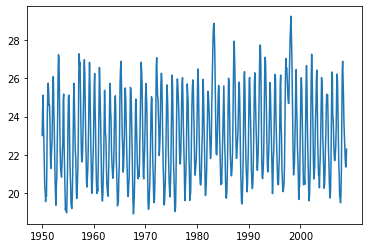

In [30]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [31]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [32]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


## Calculating monthly means across all training years

In [33]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[24.15851064 25.64957447 26.0287234  25.11765957 23.89361702 22.63170213
 21.53702128 20.61957447 20.34978723 20.6412766  21.34446809 22.44255319]


In [34]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.14851064 -1.32957447 -0.9187234  -1.48765957 -1.21361702 -1.30170213
 -1.22702128 -0.49957447 -0.78978723 -0.6512766  -1.49446809 -0.74255319]
1951 [-0.04851064 -0.45957447 -0.2887234   0.17234043  0.69638298  1.97829787
  2.28297872  1.56042553  0.94021277  1.0987234   0.99553191  0.35744681]
1952 [ 0.20148936  0.37042553  0.0512766  -0.67765957 -0.41361702 -0.70170213
 -0.80702128 -0.72957447 -0.97978723 -0.2712766  -0.51446809 -0.14255319]
1953 [-0.02851064  0.62042553  1.1912766   1.88234043  1.53638298  0.79829787
  0.42297872  0.56042553  0.71021277  0.1987234   0.16553191 -0.24255319]
1954 [-1.49851064 -0.76957447 -0.8587234  -2.66765957 -2.46361702 -1.97170213
 -2.40702128 -1.30957447 -1.32978723 -1.6612766  -1.14446809 -1.14255319]
1955 [-0.43851064 -0.67957447 -0.9087234  -0.81765957 -1.63361702 -1.43170213
 -1.01702128 -1.15957447 -1.08978723 -1.4412766  -1.51446809 -1.34255319]
1956 [-0.89851064 -0.74957447 -0.2987234  -0.72765957 -0.68361702 -0.44170213
  0.282978

In [35]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
training_anomalies = get_data(anomaly_data_dict,training_years)

In [36]:
len(training_data),len(training_anomalies)

(564, 564)

In [37]:
assert len(training_years)*12 == len(training_data)
assert len(training_years)*12 == len(training_anomalies)

### Plotting training data, mean, acf and pacf

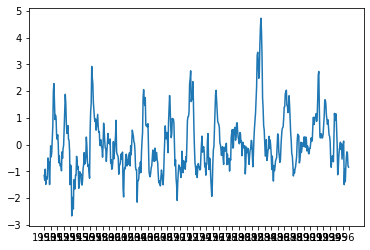

In [38]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

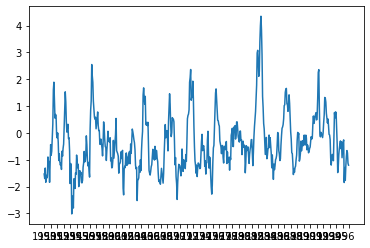

In [39]:
plt.plot(training_anomalies)
plt.xticks(range(0,len(training_anomalies)+1,12),labels=training_years)
plt.show()

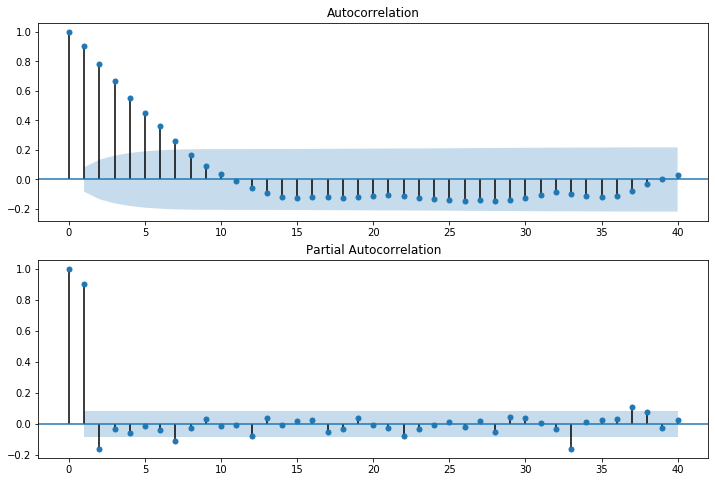

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [41]:
p=12

In [42]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [43]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

const      -0.005531
ar.L1.y     1.033317
ar.L2.y    -0.124785
ar.L3.y     0.009999
ar.L4.y    -0.044629
ar.L5.y     0.002319
ar.L6.y     0.081936
ar.L7.y    -0.065874
ar.L8.y    -0.089266
ar.L9.y     0.074104
ar.L10.y   -0.049201
ar.L11.y    0.104800
ar.L12.y   -0.093261
dtype: float64


### Getting predictions for test set

In [44]:
predictions = arma_mod.predict(start=f'{testing_years[0]}m1', end=f'{testing_years[-1]}m12', dynamic=False)
test_data = get_data(filtered_data,testing_years)
test_anomalies = get_data(anomaly_data_dict,testing_years)

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


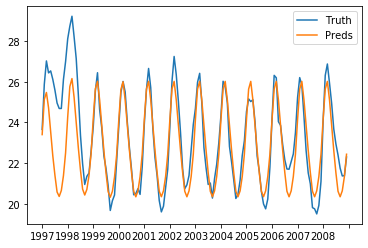

In [45]:
plt.plot(test_data,label='Truth')
plt.plot(predictions.values+np.tile(means, len(testing_years)),label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [46]:
test_mrse = mrse(test_data,predictions.values+test_anomalies)
test_re = re(test_data,predictions.values+test_anomalies)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

Test MRSE: 10.03864399750766
Test RE: 0.9962483530776958


### Grid search over different lags to find best model

For P: 1
const     -0.031653
ar.L1.y    0.902539
dtype: float64


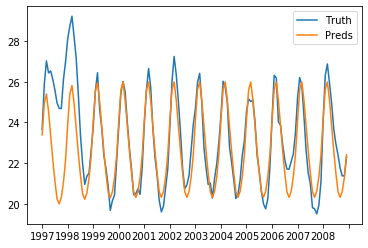

Test MRSE: 10.066888512734653
Test RE: 0.9990513762534711
For P: 2
const     -0.021834
ar.L1.y    1.047620
ar.L2.y   -0.160820
dtype: float64


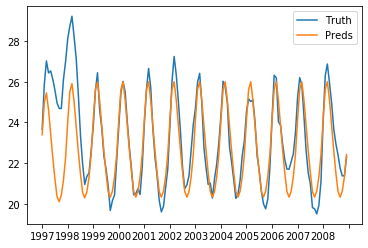

Test MRSE: 10.056220583568829
Test RE: 0.997992676805135
For P: 3
const     -0.020310
ar.L1.y    1.041494
ar.L2.y   -0.120928
ar.L3.y   -0.038045
dtype: float64


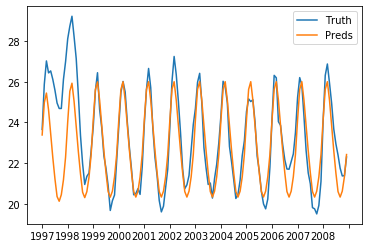

Test MRSE: 10.054683255150568
Test RE: 0.9978401102926447
For P: 4
const     -0.017815
ar.L1.y    1.039546
ar.L2.y   -0.127414
ar.L3.y    0.016083
ar.L4.y   -0.051822
dtype: float64


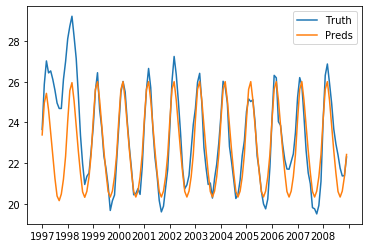

Test MRSE: 10.052444540492564
Test RE: 0.997617937278879
For P: 5
const     -0.017213
ar.L1.y    1.038867
ar.L2.y   -0.127197
ar.L3.y    0.014365
ar.L4.y   -0.038253
ar.L5.y   -0.013003
dtype: float64


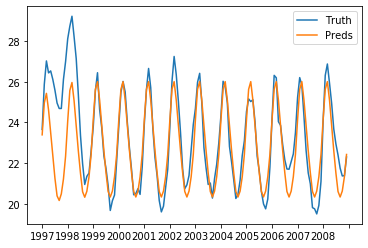

Test MRSE: 10.051821170015886
Test RE: 0.9975560731654689
For P: 6
const     -0.015281
ar.L1.y    1.038394
ar.L2.y   -0.128706
ar.L3.y    0.015057
ar.L4.y   -0.043047
ar.L5.y    0.024434
ar.L6.y   -0.035918
dtype: float64


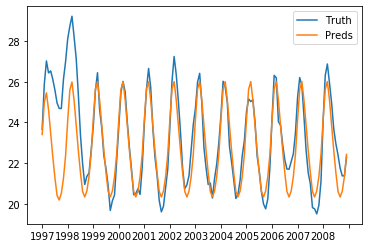

Test MRSE: 10.049667882462728
Test RE: 0.9973423780509624
For P: 7
const     -0.009122
ar.L1.y    1.034305
ar.L2.y   -0.126288
ar.L3.y    0.010160
ar.L4.y   -0.040791
ar.L5.y    0.009503
ar.L6.y    0.080175
ar.L7.y   -0.111701
dtype: float64


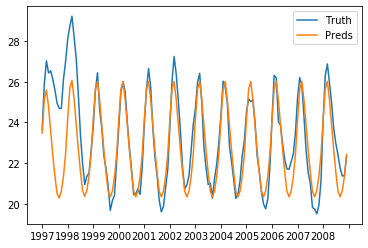

Test MRSE: 10.041956162870118
Test RE: 0.9965770567639995
For P: 8
const     -0.007758
ar.L1.y    1.030068
ar.L2.y   -0.123088
ar.L3.y    0.010185
ar.L4.y   -0.042226
ar.L5.y    0.009984
ar.L6.y    0.075255
ar.L7.y   -0.072605
ar.L8.y   -0.037677
dtype: float64


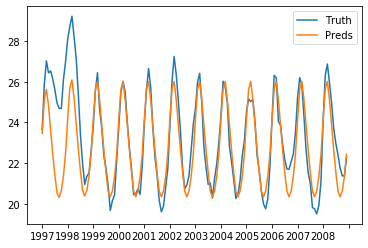

Test MRSE: 10.040215532955788
Test RE: 0.9964043143412281
For P: 9
const     -0.009906
ar.L1.y    1.031602
ar.L2.y   -0.119840
ar.L3.y    0.006612
ar.L4.y   -0.042143
ar.L5.y    0.011480
ar.L6.y    0.074672
ar.L7.y   -0.066999
ar.L8.y   -0.079864
ar.L9.y    0.040607
dtype: float64


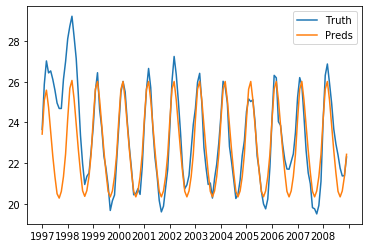

Test MRSE: 10.043077304745845
Test RE: 0.9966883203716677
For P: 10
const      -0.008998
ar.L1.y     1.032749
ar.L2.y    -0.121811
ar.L3.y     0.004388
ar.L4.y    -0.039817
ar.L5.y     0.011450
ar.L6.y     0.073550
ar.L7.y    -0.066253
ar.L8.y    -0.084036
ar.L9.y     0.069300
ar.L10.y   -0.027267
dtype: float64


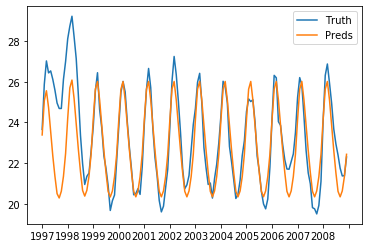

Test MRSE: 10.042286641572868
Test RE: 0.9966098539090545
For P: 11
const      -0.009267
ar.L1.y     1.032892
ar.L2.y    -0.122144
ar.L3.y     0.004731
ar.L4.y    -0.039329
ar.L5.y     0.010970
ar.L6.y     0.073555
ar.L7.y    -0.065983
ar.L8.y    -0.084259
ar.L9.y     0.070221
ar.L10.y   -0.033021
ar.L11.y    0.005431
dtype: float64


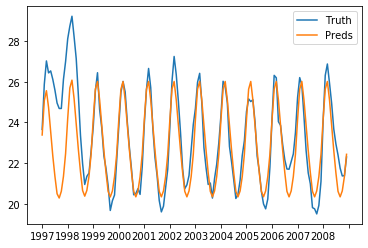

Test MRSE: 10.042524229336253
Test RE: 0.9966334324340069
For P: 12
const      -0.005531
ar.L1.y     1.033317
ar.L2.y    -0.124785
ar.L3.y     0.009999
ar.L4.y    -0.044629
ar.L5.y     0.002319
ar.L6.y     0.081936
ar.L7.y    -0.065874
ar.L8.y    -0.089266
ar.L9.y     0.074104
ar.L10.y   -0.049201
ar.L11.y    0.104800
ar.L12.y   -0.093261
dtype: float64


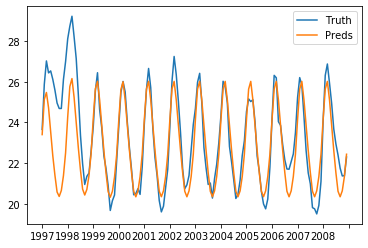

Test MRSE: 10.03864399750766
Test RE: 0.9962483530776958
For P: 13
const      -0.007122
ar.L1.y     1.037294
ar.L2.y    -0.129123
ar.L3.y     0.011815
ar.L4.y    -0.047275
ar.L5.y     0.005034
ar.L6.y     0.085813
ar.L7.y    -0.070020
ar.L8.y    -0.089048
ar.L9.y     0.076971
ar.L10.y   -0.051319
ar.L11.y    0.112121
ar.L12.y   -0.139200
ar.L13.y    0.043250
dtype: float64


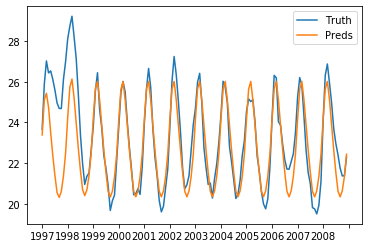

Test MRSE: 10.040657673208427
Test RE: 0.9964481929266854
For P: 14
const      -0.006930
ar.L1.y     1.037502
ar.L2.y    -0.129781
ar.L3.y     0.012335
ar.L4.y    -0.047507
ar.L5.y     0.005351
ar.L6.y     0.085504
ar.L7.y    -0.070462
ar.L8.y    -0.088574
ar.L9.y     0.076992
ar.L10.y   -0.051649
ar.L11.y    0.112315
ar.L12.y   -0.140020
ar.L13.y    0.048322
ar.L14.y   -0.004736
dtype: float64


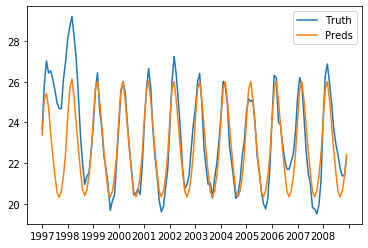

Test MRSE: 10.040469026875858
Test RE: 0.9964294714142797
For P: 15
const      -0.007773
ar.L1.y     1.037615
ar.L2.y    -0.130779
ar.L3.y     0.015155
ar.L4.y    -0.049757
ar.L5.y     0.006365
ar.L6.y     0.084131
ar.L7.y    -0.069131
ar.L8.y    -0.086719
ar.L9.y     0.075095
ar.L10.y   -0.051808
ar.L11.y    0.113671
ar.L12.y   -0.140868
ar.L13.y    0.051910
ar.L14.y   -0.026315
ar.L15.y    0.020099
dtype: float64


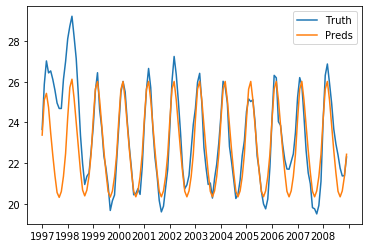

Test MRSE: 10.041406404402357
Test RE: 0.9965224980040482
For P: 16
const      -0.008589
ar.L1.y     1.037191
ar.L2.y    -0.130276
ar.L3.y     0.014106
ar.L4.y    -0.046773
ar.L5.y     0.003958
ar.L6.y     0.085227
ar.L7.y    -0.070664
ar.L8.y    -0.085189
ar.L9.y     0.076923
ar.L10.y   -0.053678
ar.L11.y    0.113367
ar.L12.y   -0.139345
ar.L13.y    0.050984
ar.L14.y   -0.022456
ar.L15.y   -0.003173
ar.L16.y    0.021679
dtype: float64


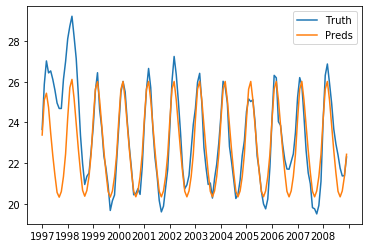

Test MRSE: 10.04232354607696
Test RE: 0.9966135163610182
For P: 17
const      -0.006452
ar.L1.y     1.038494
ar.L2.y    -0.130208
ar.L3.y     0.012476
ar.L4.y    -0.043291
ar.L5.y    -0.005178
ar.L6.y     0.092595
ar.L7.y    -0.073964
ar.L8.y    -0.080691
ar.L9.y     0.072316
ar.L10.y   -0.059382
ar.L11.y    0.119569
ar.L12.y   -0.138563
ar.L13.y    0.046032
ar.L14.y   -0.019327
ar.L15.y   -0.014783
ar.L16.y    0.091681
ar.L17.y   -0.065311
dtype: float64


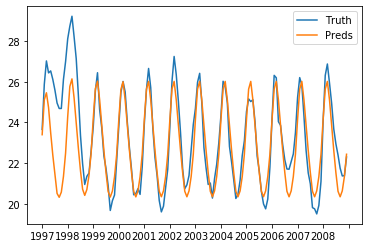

Test MRSE: 10.039438112771382
Test RE: 0.9963271621303761
For P: 18
const      -0.005771
ar.L1.y     1.035740
ar.L2.y    -0.126189
ar.L3.y     0.011638
ar.L4.y    -0.043816
ar.L5.y    -0.003397
ar.L6.y     0.086840
ar.L7.y    -0.068581
ar.L8.y    -0.083613
ar.L9.y     0.075353
ar.L10.y   -0.062750
ar.L11.y    0.116563
ar.L12.y   -0.134293
ar.L13.y    0.045539
ar.L14.y   -0.021950
ar.L15.y   -0.012809
ar.L16.y    0.084325
ar.L17.y   -0.020390
ar.L18.y   -0.042108
dtype: float64


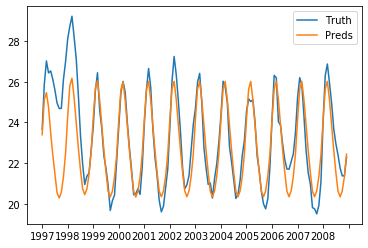

Test MRSE: 10.038011016178949
Test RE: 0.9961855351705748
For P: 19
const      -0.006753
ar.L1.y     1.037686
ar.L2.y    -0.125074
ar.L3.y     0.007363
ar.L4.y    -0.042939
ar.L5.y    -0.002722
ar.L6.y     0.084799
ar.L7.y    -0.062168
ar.L8.y    -0.089696
ar.L9.y     0.079200
ar.L10.y   -0.066617
ar.L11.y    0.120464
ar.L12.y   -0.131239
ar.L13.y    0.041240
ar.L14.y   -0.021642
ar.L15.y   -0.009768
ar.L16.y    0.082084
ar.L17.y   -0.012353
ar.L18.y   -0.091854
ar.L19.y    0.046746
dtype: float64


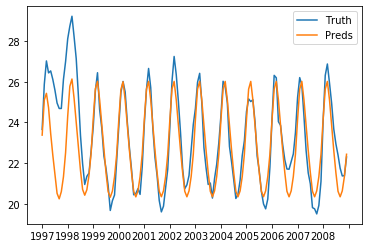

Test MRSE: 10.040082584130074
Test RE: 0.9963911203233214


In [47]:
max_p = 20
p_list = np.array(range(1,max_p))
mrse_list = []
re_list = []
for p in p_list:
    print(f'For P: {p}')
    formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))
    arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
    print(arma_mod.params)
    predictions = arma_mod.predict(start=f'{testing_years[0]}m1', end=f'{testing_years[-1]}m12', dynamic=False)
    test_data = get_data(filtered_data,testing_years)
    test_anomalies = get_data(anomaly_data_dict,testing_years)
    plt.plot(test_data,label='Truth')
    plt.plot(predictions.values+np.tile(means, len(testing_years)),label='Preds')
    plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
    plt.legend()
    plt.show()
    test_mrse = mrse(test_data,predictions.values+test_anomalies)
    test_re = re(test_data,predictions.values+test_anomalies)
    mrse_list.append(test_mrse)
    re_list.append(test_re)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

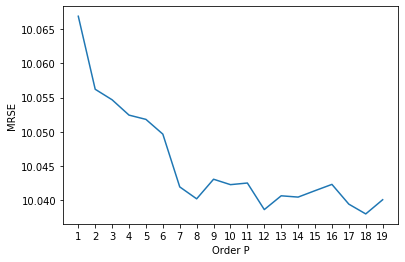

In [48]:
plt.plot(mrse_list)
plt.xticks(p_list-1,labels=p_list)
plt.ylabel('MRSE')
plt.xlabel('Order P')
plt.show()

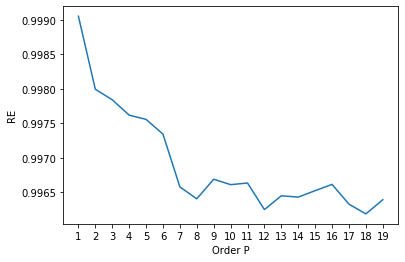

In [49]:
plt.plot(re_list)
plt.xticks(p_list-1,labels=p_list)
plt.ylabel('RE')
plt.xlabel('Order P')
plt.show()